<a href="https://colab.research.google.com/github/lphohmann/DL_microbial_gene_classifier/blob/main/build_datablock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

to do:
1. solve forward() error
2. prep meeting: clean colab notebook
3. 1D cnn ausprobieren wo channels = num distinct aa's
4. internship fragen
5. presentation date

# 1. Setting everything up

In [ ]:
#hide
# do i still need this? 
#!pip install fastai --upgrade

In [ ]:
#hide
#!pip install torchtext==0.8.1
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 2.9MB/s 
     |████████████████████████████████| 204kB 12.5MB/s 
     |████████████████████████████████| 51kB 5.0MB/s 
     |████████████████████████████████| 1.2MB 18.1MB/s 
     |████████████████████████████████| 61kB 6.3MB/s 
     |████████████████████████████████| 61kB 6.7MB/s 
Mounted at /content/gdrive


In [ ]:
#hide
import fastai
from fastbook import *

In [ ]:
import numpy as np

In [ ]:
# mount google drive to access files and set the correct working
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd drive/MyDrive/ColabNotebooks/DL_project/
!pwd

Mounted at /content/drive
/content/drive/MyDrive/ColabNotebooks/DL_project
/content/drive/MyDrive/ColabNotebooks/DL_project


# 2. Load the data and create the dataloader for 2D CNN layers


In [ ]:
# cell to check function documentation
#??nn.Conv2d

In [ ]:
# read in my data from which training and validation set will be created
trainval = pd.read_csv('trainval.csv', low_memory=False)

In [ ]:
# defining functions required for correctly loading the data
# one hot encoding function
from sklearn.preprocessing import OneHotEncoder
def OH_enc(seq: str):
    # get the categories into array
    cats = ['K', 'D', 'N', 'E', 'R', 'A', 'T', 'L', 'I', 'Q', 'C', 'F', 'G', 'W', 'M', 'S', 'H', 'P', 'V', 'Y']
    cat_array = np.array(sorted(cats), ndmin=1) #
    # get seq into array
    trunc_seq = seq[:300] # truncate sequences longer than 300 
    seq_array = np.array(list(trunc_seq))
    # one hot encode the sequence
    onehot_encoder = OneHotEncoder(categories=[cat_array],sparse=False,handle_unknown='ignore')
    onehot_encoded_seq = onehot_encoder.fit_transform(seq_array.reshape(len(seq_array), 1))
    return np.transpose(onehot_encoded_seq)

# zero padding function
def pad_along_axis(array: np.ndarray, target_length: int, axis: int = 0):
    pad_size = target_length - array.shape[axis]
    if pad_size <= 0:
        return array
    npad = [(0, 0)] * array.ndim
    npad[axis] = (0, pad_size)
    return np.pad(array, pad_width=npad, mode='constant', constant_values=0)

# combine in one function
def main_item_tfms(seq): 
    enc_seq = OH_enc(seq)
    pad_encseq_array = pad_along_axis(enc_seq,300,1) # pad to length 300, has to match seq truncate length
    return pad_encseq_array 

# categorize transform
tcat = Categorize(vocab=['K00024', 'K00121', 'K00122', 'K00123', 'K00124', 'K00126',
       'K00127', 'K00148', 'K00169', 'K00170', 'K00171', 'K00172',
       'K00194', 'K00196', 'K00197', 'K00198', 'K00200', 'K00201',
       'K00202', 'K00317', 'K00320', 'K00441', 'K00600', 'K00625',
       'K00672', 'K00830', 'K00925', 'K01007', 'K01070', 'K01499',
       'K01595', 'K01895', 'K03388', 'K03389', 'K03390', 'K05979',
       'K06034', 'K08097', 'K08691', 'K08692', 'K09733', 'K10713',
       'K10714', 'K11212', 'K11261', 'K11779', 'K11780', 'K12234',
       'K13039', 'K13788', 'K14067', 'K14080', 'K14083', 'K14940',
       'K14941', 'K15228', 'K15229', 'K18277'])

# to tensor transform and int to float tensor transform (possibly not neccessary due to always being applied)
tconv = ToTensor()
tofloat = IntToFloatTensor()
# Note: possibly add normalize transform to batch transforms
#batch_tfms = [IntToFloatTensor(), Normalize.from_stats(mean,std)]

# get x and y by specifying column in dataframe
def get_y(r): return tcat(r['Knum']) # apply the categorize trasnform 

def get_x(r): # apply the one hot encoding and padding function
    #return np.expand_dims(main_item_tfms(r['Seq']),0) # this should add a dimension at 0 leading to shape ([256, 1, 20, 300])
    return np.broadcast_to(np.expand_dims(main_item_tfms(r['Seq']),0), (3, 20, 300)).copy() # this adds 3 channel dimensions by repeating the values giving shape ([256, 3, 20, 300])

# building the datablock
dblock = DataBlock(
                 splitter = TrainTestSplitter(test_size=0.2, random_state=42, stratify=trainval[['Knum']]),
                 get_x = get_x,
                 get_y = get_y,
                 item_tfms = tconv,
                 batch_tfms = tofloat
                 )

In [ ]:
# check the dblock
#dblock.summary(trainval)

In [ ]:
# create dataloaders from datablock 
dls = dblock.dataloaders(trainval,bs=256) # batch size = 256

In [ ]:
# check one batch to make sure the dls is constructed right
x,y = dls.one_batch()
#y # these should be the targets 
#x # and these the encoded sequences

# check the shape --> Conv2d layers expect input with the shape (n_samples, channels, height, width)
x.shape # torch.Size([256, 3, 20, 300])

torch.Size([256, 3, 20, 300])

In [ ]:
# monkey patch to solve error arising from dls changeing tensor type 
def _conv_forward(self, input, weight):
    input= input.type(torch.FloatTensor).cuda() # added this line to change the tensor type
    #input= input.cuda()
    if self.padding_mode != 'zeros':
        return F.conv2d(F.pad(input, self._reversed_padding_repeated_twice, mode=self.padding_mode),
                        weight, self.bias, self.stride,
                        _pair(0), self.dilation, self.groups)
    return F.conv2d(input, weight, self.bias, self.stride,
                    self.padding, self.dilation, self.groups)

# replace in the module
nn.Conv2d._conv_forward = _conv_forward

# 3. Building and testing initial models 

In [ ]:
# model 3
# alt. cov function with batchnorm layer 
def conv(ni, nf, ks=(21, 9), act=True): # i think a non square kernel makes more sense
    # note: better to apply different stride (e.g. (2,1))?
    layers = [nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=(ks[0]//2,ks[1]//2))] # (3, 5), stride=(2, 1), padding=(4, 2) # padding=ks//2)
    layers.append(nn.BatchNorm2d(nf))
    if act: layers.append(nn.ReLU())
    return nn.Sequential(*layers)
# the model
def simple_cnn(): 
    return sequential(  # start 
        conv(1 ,8), # 1 input channel, 8 convolutions
        conv(8 ,16),  
        conv(16,32),  
        conv(32,64),  
        conv(64,128),
        conv(128,58, act=False),  
        Flatten(),
    )
# fit
def fit(epochs=1, lr=0.06):
    learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy,
                        metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit_one_cycle(epochs, lr) # make training more stable with fit_one_cycle
    return learn
# fit the model
learn = fit(epochs=3)


/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,2.876177,2.894239,0.277263,1:09:35
1,2.747020,2.749356,0.306607,1:08:57
2,2.701354,2.705941,0.302624,1:10:26


In [ ]:
learn.summary()

In [ ]:
learn.save('model1')

Path('models/model1.pth')

In [ ]:
learn = Learner.load('models/model1.pth')

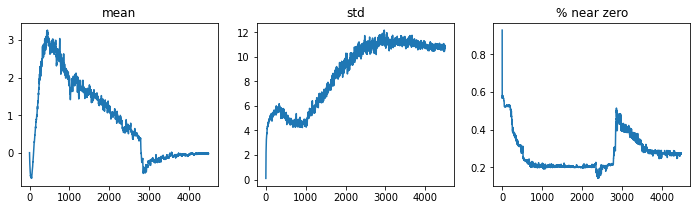

In [ ]:
# model 3 checking
# checking activation
learn.activation_stats.plot_layer_stats(-2) # check activations at the end, shouldnt be near zero
#learn.activation_stats.color_dim(-4)
# view learning rate
#learn.recorder.plot_sched()

In [ ]:
learn.activation_stats.color_dim(-4)

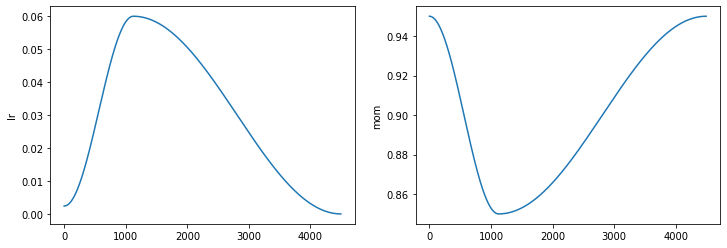

In [ ]:
learn.recorder.plot_sched()

In [ ]:
# train for more epochs
learn = fit(5, lr=0.1)

how to choose hyperparameters:
stride:
kernel size:
padding: 


In [ ]:
# fit and train 
epochs=1
lr=0.06
learn = learn.fit_one_cycle(epochs, lr) # make training more stable with fit_one_cycle

In [ ]:
# check what mistakes the model is making (classifying one category mistakenly as another one)
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
# save model
learn.save('model')

# 4. 2D CNN with kernel = (height,x)

In [ ]:
ConvLayer??

Object `ConvLayer` not found.


In [ ]:
# ConvLayer creates a sequence of convolutional (ni to nf), ReLU (if use_activ) and norm_type layers
def block(ni, nf): return ConvLayer(ni, nf, stride=2, ndim=2, ks=(20,6), padding=(0,3))

In [ ]:
def get_model():
    return nn.Sequential(
        block(1, 16),
        block(16, 32),
        block(32, 64),
        block(64, 128),
        block(128, 256),
        nn.AdaptiveAvgPool2d(1),
        Flatten(),
        nn.Linear(256, 58)) 

In [ ]:
# create learn object
learn = Learner(dls, get_model(), loss_func=nn.CrossEntropyLoss(), metrics=accuracy)

In [ ]:
learn.summary()

In [ ]:
learn.lr_find() # choose an adequate lr

In [ ]:
# fit and train 
epochs=1
lr=0.06
learn = learn.fit_one_cycle(epochs, lr) # make training more stable with fit_one_cycle

# 5. Load the data and create the dataloader for 1D CNN layers


In [ ]:
# read in my data from which training and validation set will be created
trainval = pd.read_csv('trainval.csv', low_memory=False)

In [ ]:
# defining functions required for building the DataBlock
# one hot encoding function
from sklearn.preprocessing import OneHotEncoder
def OH_enc(seq: str):
    # get the categories into array
    cats = ['K', 'D', 'N', 'E', 'R', 'A', 'T', 'L', 'I', 'Q', 'C', 'F', 'G', 'W', 'M', 'S', 'H', 'P', 'V', 'Y']
    cat_array = np.array(sorted(cats), ndmin=1) #
    # get seq into array
    trunc_seq = seq[:300] # truncate sequences longer than 300 
    seq_array = np.array(list(trunc_seq))
    #one hot encode the sequence
    onehot_encoder = OneHotEncoder(categories=[cat_array],sparse=False,handle_unknown='ignore')
    onehot_encoded_seq = onehot_encoder.fit_transform(seq_array.reshape(len(seq_array), 1))
    return np.transpose(onehot_encoded_seq)

# zero padding function
def pad_along_axis(array: np.ndarray, target_length: int, axis: int = 0):
    pad_size = target_length - array.shape[axis]
    if pad_size <= 0:
        return array
    npad = [(0, 0)] * array.ndim
    npad[axis] = (0, pad_size)
    return np.pad(array, pad_width=npad, mode='constant', constant_values=0)

# combine in one function
def main_item_tfms(seq): # added -> None because the tensor shape later is 1,2820 and i think it should be 20,2820
    enc_seq = OH_enc(seq)
    pad_encseq_array = pad_along_axis(enc_seq,300,1)
    return pad_encseq_array 

# categorize function
tcat = Categorize(vocab=['K00024', 'K00121', 'K00122', 'K00123', 'K00124', 'K00126',
       'K00127', 'K00148', 'K00169', 'K00170', 'K00171', 'K00172',
       'K00194', 'K00196', 'K00197', 'K00198', 'K00200', 'K00201',
       'K00202', 'K00317', 'K00320', 'K00441', 'K00600', 'K00625',
       'K00672', 'K00830', 'K00925', 'K01007', 'K01070', 'K01499',
       'K01595', 'K01895', 'K03388', 'K03389', 'K03390', 'K05979',
       'K06034', 'K08097', 'K08691', 'K08692', 'K09733', 'K10713',
       'K10714', 'K11212', 'K11261', 'K11779', 'K11780', 'K12234',
       'K13039', 'K13788', 'K14067', 'K14080', 'K14083', 'K14940',
       'K14941', 'K15228', 'K15229', 'K18277'])

# questoin, do i have to also apply the ToTensor()? https://docs.fast.ai/tutorial.pets.html
# -> answer : I think ToTensor() is always applied, like to float tensor
tconv = ToTensor()
# try to add this as well (add a batch_tfms (or after_batch_tfms) line to DataBlock)
#batch_tfms = [IntToFloatTensor(), Normalize.from_stats(mean,std)]
tofloat = IntToFloatTensor()

# get_x and y by specifying column in dataframe
def get_y(r): return tcat(r['Knum']) # apply the categorize trasnform 

# this should be (bs,20,300)
def get_x(r): # apply the one hot encoding and padding function
    #return main_item_tfms(r['Seq']) 
    return main_item_tfms(r['Seq'])

# building the datablock
dblock = DataBlock(
                 splitter = TrainTestSplitter(test_size=0.2, random_state=42, stratify=trainval[['Knum']]),
                 get_x = get_x,
                 get_y = get_y,
                 item_tfms = tconv,
                 batch_tfms = tofloat
                 )

# checking it
#dblock.summary(trainval)

In [ ]:
#dblock.summary(trainval)

In [ ]:
# create dataloaders from datablock 
dls = dblock.dataloaders(trainval,bs=256)

In [ ]:
# check one batch to make sure the dls is constructed right
x,y = dls.one_batch()
#y # these should be the targets 
#x # and these the encoded sequences

# check the shape
x.shape #torch.Size([256, 20, 300])

torch.Size([256, 20, 300])

In [ ]:
# monkey patch to change back tensor type
def _conv_forward(self, input: Tensor, weight: Tensor, bias: Optional[Tensor]):
    input= input.type(torch.FloatTensor).cuda() # added this line to change the tensor type
    if self.padding_mode != 'zeros':
        return F.conv1d(F.pad(input, self._reversed_padding_repeated_twice, mode=self.padding_mode),
                        weight, bias, self.stride,
                        _single(0), self.dilation, self.groups)
    return F.conv1d(input, weight, bias, self.stride,
                    self.padding, self.dilation, self.groups)
# replace in the module
nn.Conv1d._conv_forward = _conv_forward

# 6. 1D CNN with 20 channels corresponding to the number of distinct amino acids

In [ ]:
# ConvLayer creates a sequence of convolutional (ni to nf), ReLU (if use_activ) and norm_type layers
def block(ni, nf): return ConvLayer(ni, nf, stride=2, ndim=1, ks=5)

In [ ]:
def get_model():
    return nn.Sequential(
        block(20, 32), #how to handle this
        block(32, 64),
        block(64, 128),
        block(128, 256),
        nn.AdaptiveAvgPool1d(1),
        Flatten(),
        nn.Linear(256, 58)) 

In [ ]:
# create learn object
learn = Learner(dls, get_model(), loss_func=nn.CrossEntropyLoss(), metrics=accuracy)

In [ ]:
learn.summary()

Sequential (Input shape: 256)
Layer (type)         Output Shape         Param #    Trainable 
                     256 x 32 x 150      
Conv1d                                    3200       True      
BatchNorm1d                               64         True      
ReLU                                                           
____________________________________________________________________________
                     256 x 64 x 75       
Conv1d                                    10240      True      
BatchNorm1d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     256 x 128 x 38      
Conv1d                                    40960      True      
BatchNorm1d                               256        True      
ReLU                                                           
__________________________________________________

In [ ]:
learn.lr_find() # choose an adequate lr

In [ ]:
# fit and train 
epochs=1
lr=0.06
learn = learn.fit_one_cycle(epochs, lr) # make training more stable with fit_one_cycle

# 7. ResNet: just an idea, try at the end


In [ ]:
ConvLayer??

Object `ConvLayer` not found.


In [ ]:
# function to quickly create a learn object
def get_learner(model):
    return Learner(dls, model, loss_func=nn.CrossEntropyLoss(), metrics=accuracy) #.to_fp16()

In [ ]:
# ResBlock that is able to handle changing shape in the skip connection
def _conv_block(ni,nf,stride):
    return nn.Sequential(
        ConvLayer(ni, nf, stride=stride), # look into ConvLayer
        ConvLayer(nf, nf, act_cls=None, norm_type=NormType.BatchZero))
class ResBlock(Module):
    def __init__(self, ni, nf, stride=1):
        self.convs = _conv_block(ni,nf,stride)
        self.idconv = noop if ni==nf else ConvLayer(ni, nf, 1, act_cls=None)
        self.pool = noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)

    def forward(self, x):
        return F.relu(self.convs(x) + self.idconv(self.pool(x)))

In [ ]:
# ResNet: instead of starting with ResNet blocks, it begins with a few 
# convolutional layers followed by a max pooling layer (the stem of the network)
def _resnet_stem(*sizes): # using convulational layers
    return [
        ConvLayer(sizes[i], sizes[i+1], 3, stride = 2 if i==0 else 1)
            for i in range(len(sizes)-1)
    ] + [nn.MaxPool2d(kernel_size=3, stride=2, padding=1)]

In [ ]:
nn.Sequential??

In [ ]:
# modern ResNet
# uses the four groups of ResNet blocks, with 64, 128, 256, then 512 filters.
# Each group starts with a stride-2 block, except for the first one, since it’s just after a
# MaxPooling laye
class ResNet(nn.Sequential):
    def __init__(self, n_out, layers, expansion=1):
        stem = _resnet_stem(3,32,32,64)
        self.block_szs = [64, 64, 128, 256, 512]
        for i in range(1,5): self.block_szs[i] *= expansion
        blocks = [self._make_layer(*o) for o in enumerate(layers)]
        super().__init__(*stem, *blocks,
                         nn.AdaptiveAvgPool2d(1), Flatten(),
                         nn.Linear(self.block_szs[-1], n_out))
    # function to create a series of n_layers blocks. The first one is going from ch_in to ch_out with 
    # the indicated stride, and all the others are blocks of stride 1 with ch_out to ch_out tensors
    def _make_layer(self, idx, n_layers):
        stride = 1 if idx==0 else 2
        ch_in,ch_out = self.block_szs[idx:idx+2]
        return nn.Sequential(*[
            ResBlock(ch_in if i==0 else ch_out, ch_out, stride if i==0 else 1)
            for i in range(n_layers)
        ])

In [ ]:
# bottleneck layers, replace ResBlock in ResNet
def _conv_block(ni,nf,stride):
    return nn.Sequential(
        ConvLayer(ni, nf//4, 1),
        ConvLayer(nf//4, nf//4, stride=stride), 
        ConvLayer(nf//4, nf, 1, act_cls=None, norm_type=NormType.BatchZero))

In [ ]:
# various versions of the models (ResNet-18, -34, -50, etc.) just change the number of blocks in each of those groups
# definition of a ResNet-18
#rn = ResNet(dls.c, [2,2,2,2]) # dls c should be zthe number of outputs
rn = ResNet(58, [2,2,2,2])

In [ ]:
# create learner
learn = get_learner(rn)

In [ ]:
learn.summary() 
# TypeError: _conv_forward() takes 3 positional arguments but 4 were given (in Cov2d)

In [ ]:
# find lr
learn.lr_find() # choose an adequate lr

In [ ]:
# train
learn.fit_one_cycle(5, 3e-3)

In [ ]:
# ResNet-50 with group sizes of (3,4,6,3)
rn = ResNet(dls.c, [3,4,6,3], 4) # pass in 4 because we need to start with four times fewer channels and we’ll end with four times more channels.

In [ ]:
# train
learn = get_learner(rn)
learn.fit_one_cycle(20, 3e-3)

In [ ]:
# try adding Mixup ??? what is that p456